### Importing Libs

In [1]:
# Importing Libs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

sns.set_theme(style="darkgrid", rc={'figure.figsize':(16,10)})

### Creating DataFrames

Inicialmente, serão criados os datasets com os dados disponibilizados pela Olist:

In [4]:
# Defining datasets paths

CUSTOMERS_PATH = r"datasets/olist_customers_dataset.csv"
GEOLOCATION_PATH = r"datasets/olist_geolocation_dataset.csv"
ORDER_ITEM_PATH = r"datasets/olist_order_items_dataset.csv"
ORDER_PAYMENTS_PATH = r"datasets/olist_order_payments_dataset.csv"
ORDER_REVIEWS_PATH = r"datasets/olist_order_reviews_dataset.csv"
ORDERS_PATH = r"datasets/olist_orders_dataset.csv"
PRODUCTS_PATH = r"datasets/olist_products_dataset.csv"
SELLERS_PATH = r"datasets/olist_sellers_dataset.csv"
PROD_CATEG_PATH = r"datasets/product_category_name_translation.csv"

In [5]:
# DataFrames

df_customers = pd.read_csv(CUSTOMERS_PATH)
df_geoloc = pd.read_csv(GEOLOCATION_PATH)
df_order_item = pd.read_csv(ORDER_ITEM_PATH)
df_order_pay = pd.read_csv(ORDER_PAYMENTS_PATH)
df_order_rev = pd.read_csv(ORDER_REVIEWS_PATH)
df_orders = pd.read_csv(ORDERS_PATH)
df_product = pd.read_csv(PRODUCTS_PATH)
df_seller = pd.read_csv(SELLERS_PATH)
df_prod_cat = pd.read_csv(PROD_CATEG_PATH)

A partir dos DataFrames, será obtido um DataFrame utilizado para o EDA através do método `merge`:

In [7]:
# Merging DataFrames

# Merge Customer ID + Order ID
df_customer_orders = pd.merge(df_customers, df_orders, on='customer_id')

# Merge Customer ID + Order ID + Seller ID
df_customer_orders_seller = pd.merge(df_customer_orders, df_order_item, on='order_id')

# Merge Customer ID + Order ID + Seller ID + State Seller
df_cust_ord_sel_state = pd.merge(df_customer_orders_seller, df_seller, on='seller_id')

# Merge Customer ID + Order ID + Seller ID + State Seller + Paymen Type
df_cust_ord_sel_state = pd.merge(df_cust_ord_sel_state, df_order_pay, on='order_id')

# Merge Customer ID + Order ID + Seller ID + State Seller + paymenttype + Produt Category
df_eda = pd.merge(df_cust_ord_sel_state, df_product, on='product_id')

## Data Cleaning and Exploration

Abaixo, serão visualizadas as features que obtemos por meio do método `info()`, assim como os tipos:

In [10]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117601 entries, 0 to 117600
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    117601 non-null  object 
 1   customer_unique_id             117601 non-null  object 
 2   customer_zip_code_prefix       117601 non-null  int64  
 3   customer_city                  117601 non-null  object 
 4   customer_state                 117601 non-null  object 
 5   order_id                       117601 non-null  object 
 6   order_status                   117601 non-null  object 
 7   order_purchase_timestamp       117601 non-null  object 
 8   order_approved_at              117586 non-null  object 
 9   order_delivered_carrier_date   116356 non-null  object 
 10  order_delivered_customer_date  115034 non-null  object 
 11  order_estimated_delivery_date  117601 non-null  object 
 12  order_item_id                 

Existem 6 atributos referentes a datas,e terão seus tpos covertidos de `object` para `datetime64`, facilitando operações posterirores envolvendo tempo e datas:

In [12]:
df_eda['order_purchase_timestamp'] = pd.to_datetime(df_eda['order_purchase_timestamp'])

Serão então removidas as features que não serão utilizadas nas análises, e adicionadas features a respeito de meses e anos:

In [14]:
df_eda.drop(['seller_id',
             'customer_zip_code_prefix', 'customer_city', 
             'order_approved_at', 'order_delivered_carrier_date', 
             'order_delivered_customer_date',  'order_estimated_delivery_date',
             'shipping_limit_date', 'seller_zip_code_prefix',   
             'seller_city', 'seller_state', 'payment_sequential',	
             'payment_type', 'payment_installments',
             'product_name_lenght', 'product_description_lenght',
             'product_photos_qty', 'product_weight_g',
             'product_length_cm', 'product_height_cm',
             'product_width_cm'], axis=1, inplace=True)

Após isso, veremos quantos valores nulos temos em cada feature:

In [16]:
df_eda.isnull().sum()

customer_id                    0
customer_unique_id             0
customer_state                 0
order_id                       0
order_status                   0
order_purchase_timestamp       0
order_item_id                  0
product_id                     0
price                          0
freight_value                  0
payment_value                  0
product_category_name       1698
dtype: int64

Boa partedos valores nulos encontrados são relativos aos tempos de entrega do produto.

Em uma primeira tentativa de filtrar isso, iremos ver como se comporta os valores da feature `order_status`, informando se o produto foi ou não entregue:

In [18]:
df_status = df_eda['order_status'].value_counts().reset_index() # Count values of each status and create a new DataFrame
df_status.columns = ["order_status", "count_status"] # Rename Columns
df_status['pct'] = round((100*df_status["count_status"]/df_status["count_status"].sum()),3).astype(str) + '%' # Add new column with percentages of status
df_status.sort_values("count_status", ascending=False, inplace = True)
df_status

,order_status,count_status,pct
0,delivered,115035,97.818%
1,shipped,1244,1.058%
2,canceled,566,0.481%
3,processing,375,0.319%
4,invoiced,371,0.315%
5,unavailable,7,0.006%
6,approved,3,0.003%


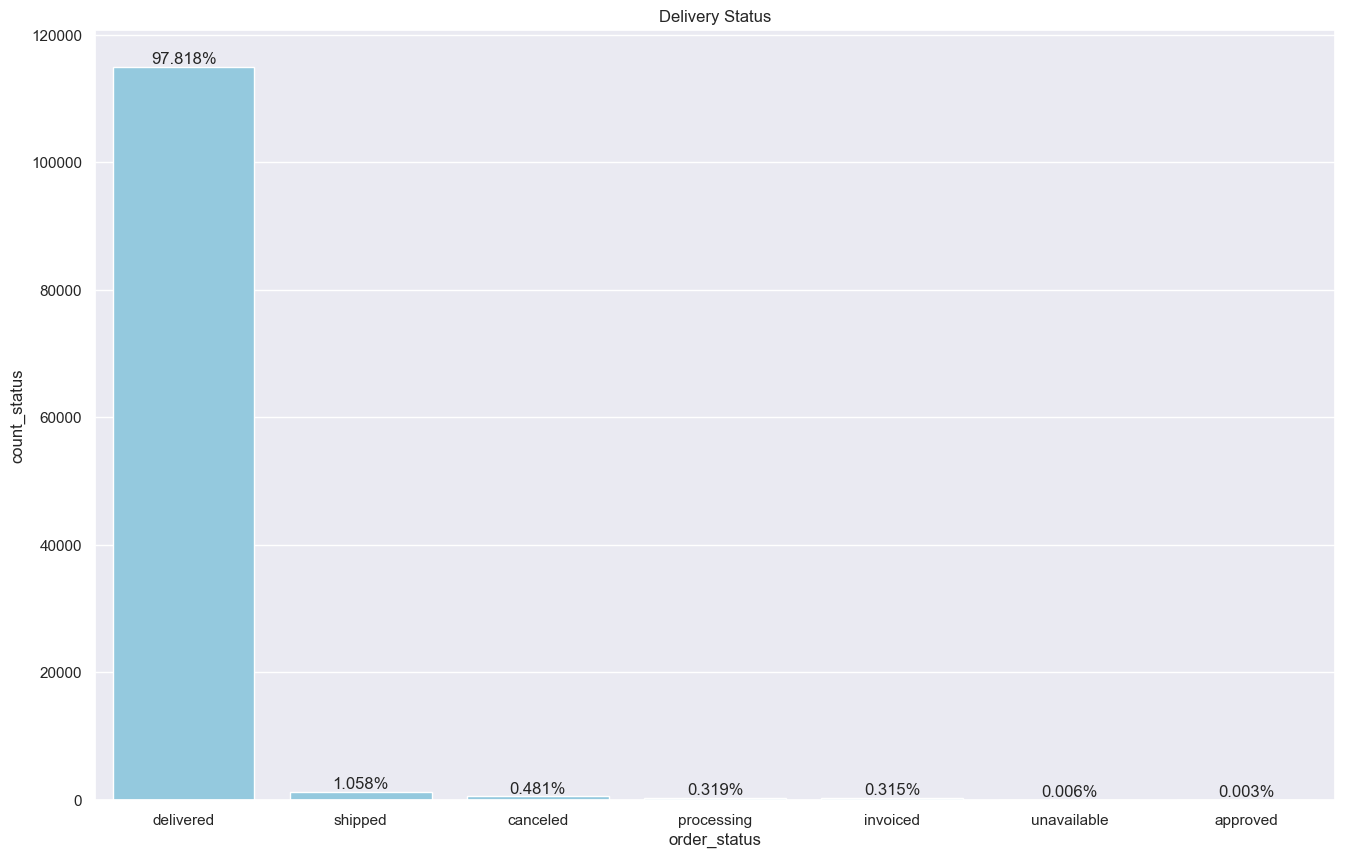

In [19]:
ax = sns.barplot(data = df_status, y='count_status', x="order_status", errorbar=None, color='skyblue')
bars = ax.containers[0]
ax.bar_label(bars, labels = df_status["pct"])
ax.set_title('Delivery Status');

Observamos então, que mais de 97% dos pedidos obtiveram o status `delivered`, ou seja, foram corretaemntes entregues. Então, para as análises que iremos fazer agora, utilizaremos apenas os quais foram entregues, ou seja, `order_status = delivered`

In [21]:
df_delivered = df_eda[df_eda['order_status']== 'delivered']
df_delivered.head()

,customer_id,customer_unique_id,customer_state,order_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_value,product_category_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,146.87,moveis_escritorio
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,1,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,335.48,utilidades_domesticas
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,1,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,157.73,moveis_escritorio
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,1,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,173.30,moveis_escritorio
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,1,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,252.25,casa_conforto


Novamente, iremos ver quantos valores nulos temos:

In [25]:
df_delivered.isnull().sum()

customer_id                    0
customer_unique_id             0
customer_state                 0
order_id                       0
order_status                   0
order_purchase_timestamp       0
order_item_id                  0
product_id                     0
price                          0
freight_value                  0
payment_value                  0
product_category_name       1628
dtype: int64

In [26]:
df_delivered.shape

(115035, 12)

Como faremos uam análise sobre os tempos de entrega, serão removidos os valores nulos correspondentes a isso. Quanto as valores nulos a respeito da categoria do produto (`product_category_name`), estes não irão causar problemas às análises posteriores, e por isso não serão removidos:

In [28]:
# Considerar dropar nulos
1628/len(df_delivered)

0.014152214543399835

In [30]:
df_delivered.shape

(115035, 12)

Antes de iniciarmos nossa análise, é interessante ver o primeiro e último momenot que foram feitos pedidos:

In [33]:
min_order = df_eda['order_purchase_timestamp'].min()
max_order = df_eda['order_purchase_timestamp'].max()

print("The first order was made at {} and the last one was made at {}".format(min_order, max_order))

The first order was made at 2016-09-04 21:15:19 and the last one was made at 2018-09-03 09:06:57


# EDA

In [40]:
df_delivered.head()

,customer_id,customer_unique_id,customer_state,order_id,order_status,order_purchase_timestamp,order_item_id,product_id,price,freight_value,payment_value,product_category_name
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,146.87,moveis_escritorio
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,1,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,335.48,utilidades_domesticas
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,1,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,157.73,moveis_escritorio
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,1,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,173.30,moveis_escritorio
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,1,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,252.25,casa_conforto


Normalmente para este tipo de análise, é utilizado a data do dia atual, mas como os períodos estão distantes utilizaremos a última data + 1 dia:

In [49]:
ref_date = max(df_delivered['order_purchase_timestamp']) + dt.timedelta(days=1)

In [50]:
ref_date

Timestamp('2018-08-30 15:00:37')

In [52]:
df_rfm  = df_delivered.groupby('customer_unique_id').agg(
    recency = ('order_purchase_timestamp', lambda x: (ref_date - x.max()).days),
    frequency = ('customer_unique_id', 'count'), 
    monetary = ('price', 'sum')
)

In [53]:
df_rfm

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
ffff371b4d645b6ecea244b27531430a,568,1,89.90


In [56]:
df_rfm.sort_values(by='monetary', ascending=False)

,recency,frequency,monetary
customer_unique_id,,,
0a0a92112bd4c708ca5fde585afaa872,334,8,13440.00
c4b224d2c784bae11ae98b6ae9f2454c,458,15,10856.10
85963fd37bfd387aa6d915d8a1065486,196,24,9888.00
be74c431147c32ab2d7c7cef5e4a995f,111,7,9520.14
edf81e1f3070b9dac83ec83dacdbb9bc,498,2,7998.00
...,...,...,...
44eba5de8af60ec8b057ab4983f0868a,58,1,3.00
cf3839da0d9492ad151690b65f45d800,209,1,2.99
bd06ce0e06ad77a7f681f1a4960a3cc6,350,1,2.29


In [57]:
df_rfm.sort_values(by='frequency', ascending=False)

,recency,frequency,monetary
customer_unique_id,,,
9a736b248f67d166d2fbb006bcb877c3,386,75,2847.78
6fbc7cdadbb522125f4b27ae9dee4060,341,38,3039.62
f9ae226291893fda10af7965268fb7f6,536,35,5436.50
569aa12b73b5f7edeaa6f2a01603e381,449,26,1299.74
5419a7c9b86a43d8140e2939cd2c2f7e,110,24,359.76
...,...,...,...
5ba849a3f0341ce2d82476c0c79f77d8,442,1,49.00
5ba6b74fb0741b0f6add7f5a5f7d61b6,7,1,79.90
5ba6756bffba1fe9727a104af43cf3e9,30,1,129.90


In [58]:
quantiles = df_rfm.quantile(q=[.25,.5,.75])
quantiles

,recency,frequency,monetary
0.25,114.0,1.0,48.9
0.50,219.0,1.0,89.9
0.75,346.0,1.0,159.8


In [59]:
def rfm_scores(x, q, analysis, is_recency = False):

    if is_recency:
        if x <= q[analysis][0.25]:
            return 1
        elif x <= q[analysis][0.5]:
            return 2
        elif x <= q[analysis][0.75]:
            return 3
        else:
            return 4


    else:
        if x <= q[analysis][0.25]:
            return 4
        elif x <= q[analysis][0.5]:
            return 3
        elif x <= q[analysis][0.75]:
            return 2
        else:
            return 1

In [60]:
df_rfm['r_score'] = df_rfm['recency'].apply(rfm_scores, args = (quantiles, 'recency', True))
df_rfm['f_score'] = df_rfm['frequency'].apply(rfm_scores, args = (quantiles, 'frequency', False))
df_rfm['m_score'] = df_rfm['monetary'].apply(rfm_scores, args = (quantiles, 'monetary', True))

In [68]:
df_rfm.sort_values(by='frequency',ascending=False)

,recency,frequency,monetary,r_score,f_score,m_score
customer_unique_id,,,,,,
9a736b248f67d166d2fbb006bcb877c3,386,75,2847.78,4,1,4
6fbc7cdadbb522125f4b27ae9dee4060,341,38,3039.62,3,1,4
f9ae226291893fda10af7965268fb7f6,536,35,5436.50,4,1,4
569aa12b73b5f7edeaa6f2a01603e381,449,26,1299.74,4,1,4
5419a7c9b86a43d8140e2939cd2c2f7e,110,24,359.76,1,1,4
...,...,...,...,...,...,...
5ba849a3f0341ce2d82476c0c79f77d8,442,1,49.00,4,4,2
5ba6b74fb0741b0f6add7f5a5f7d61b6,7,1,79.90,1,4,2
5ba6756bffba1fe9727a104af43cf3e9,30,1,129.90,1,4,3


In [70]:
df_rfm['rfm_segment'] = df_rfm['r_score'].astype(str) + df_rfm['f_score'].astype(str) + df_rfm['m_score'].astype(str)

In [72]:
df_rfm

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,143
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,4,1,241
0000f46a3911fa3c0805444483337064,537,1,69.00,4,4,2,442
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,4,1,341
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,4,4,344
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,4,1,4,414
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,3,4,2,342
ffff371b4d645b6ecea244b27531430a,568,1,89.90,4,4,2,442


In [ ]:
def split_sum_number(val):
    return sum([int(d) for d in str(val)])

df_rfm['rfm_score'] = df_rfm['rfm_segment'].apply(split_sum_number)

In [106]:
df_rfm

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,143,8
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,4,1,241,7
0000f46a3911fa3c0805444483337064,537,1,69.00,4,4,2,442,10
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,4,1,341,8
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,4,4,344,11
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,4,1,4,414,9
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,3,4,2,342,9
ffff371b4d645b6ecea244b27531430a,568,1,89.90,4,4,2,442,10


In [110]:
def customer_value(score):
    if score < 5:
        return "Low Value"
    elif score < 9:
        return "Medium Value"
    else:
        return "High Value"

In [112]:
df_rfm['customer_value'] = df_rfm['rfm_score'].apply(customer_value)

In [114]:
df_rfm

,recency,frequency,monetary,r_score,f_score,m_score,rfm_segment,rfm_score,customer_value
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1,4,3,143,8,Medium Value
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,2,4,1,241,7,Medium Value
0000f46a3911fa3c0805444483337064,537,1,69.00,4,4,2,442,10,High Value
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,3,4,1,341,8,Medium Value
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,3,4,4,344,11,High Value
...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00,4,1,4,414,9,High Value
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,3,4,2,342,9,High Value
ffff371b4d645b6ecea244b27531430a,568,1,89.90,4,4,2,442,10,High Value
